# Iterative Training on Coughvid data

## 1. Preparing the environment

First, the colab is mounted onto the drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Libraries are imported for processing and training purpose

In [ ]:
# File handling
import os
import pandas as pd

In [ ]:
# Audio data handling
import librosa
import librosa.util
import numpy as np

In [ ]:
# Machinelearning
# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# tensor flow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Reshape, Bidirectional, Input, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications

from tensorflow_hub import KerasLayer

# Regularization
from tensorflow.keras.regularizers import l2

# Metrics
from tensorflow.keras.metrics import Precision, Recall, AUC

In [ ]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# !nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# # run this to clear GPU memory if needed
# import torch
# torch.cuda.empty_cache()

# import tensorflow as tf
# tf.keras.backend.clear_session()

## 2. Data preparation

You should only use the training and testing folder

In [ ]:
# check and verify the folders to access the data prepared earlier
metadata_path = "/content/drive/My Drive/AML/Data/dataset2_coughvid/" # update this to local version
print(os.listdir(metadata_path))

['coughvid_raw', 'labels', 'coughvid_processed', 'coughvid_train_14mar', 'coughvid_test_14mar']


Specify the training and testing file folder (loading file names)

In [ ]:
# for standarising in all sub-datasets, a function is used
def list_files(directory, label):
    files_list = os.listdir(directory)
    total_files = len(files_list)
    sample_files = files_list[:10]
    print(f"Total {label} Files: {total_files}")
    print(f"Sample {label} Files:", sample_files)
    return total_files

In [ ]:
# Show distribution of labels
def plot_distribution(counts, labels, title):
    total = sum(counts)
    percentages = [(count / total) * 100 for count in counts]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labels, counts, color=['lightblue', 'orange'])
    plt.xlabel("Dataset Type")
    plt.ylabel("Number of Files")
    plt.title(title)

    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width()/2, 10, f'{percentage:.1f}%',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

In [ ]:
train_dir = os.path.join(metadata_path, 'coughvid_train_14mar') # use training folder specified above
test_dir = os.path.join(metadata_path, 'coughvid_test_14mar') # use test folder specified above

# Process train and test directories
total_train_files = list_files(train_dir, "Train")
total_test_files = list_files(test_dir, "Test")

Total Train Files: 1871
Sample Train Files: ['63966209-4f8e-49a3-b634-d77b53ca9111.wav', '77b10e13-74b7-435c-ab67-854ad713af63.wav', '8ac2ef46-05fb-4f68-bb2d-ca5b1e51ed7f.wav', '3a325d6e-929d-48f4-b640-36e08fa37cf4.wav', '380bc7f0-d950-450c-9f5e-43c7c3f4c132.wav', '63f67eee-4a31-438a-86e8-96cb3760355c.wav', '9f4770aa-245b-4264-b872-98a2c45e9f56.wav', '34b77763-a4a4-4beb-aeaa-02ef8298ef31.wav', '309f7a85-57c3-4b1f-baa9-d1290d1d1b23.wav', '3b6a0157-04a2-46cd-b5a7-299595293a2d.wav']
Total Test Files: 468
Sample Test Files: ['7869b66e-5c53-42b8-8741-8e7398f78137.wav', 'e80023d9-392a-407a-9580-9c66eb45d7bd.wav', '37347587-048a-4a1c-a100-7cf820711428.wav', 'f0bc6079-5c16-4c95-91be-ddffc7bb37b0.wav', 'ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav', '39e4cc19-0db4-492a-b580-9fc4e4ab62ea.wav', 'f76b3127-9c87-42ad-a745-6db235e9d632.wav', '34bcd0cb-bbfb-4947-84c9-79a07c28a7c1.wav', '1e4aef1f-a0d0-414b-8f09-b588a455111c.wav', 'ae7ee0f8-d516-451d-b7a8-b855b638d74e.wav']


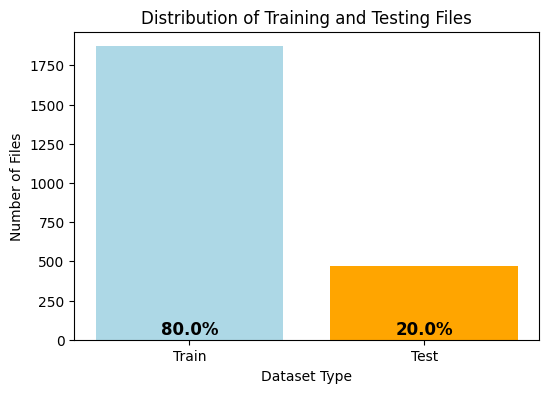

In [ ]:
# Plot distribution
plot_distribution([total_train_files, total_test_files], ["Train", "Test"], "Distribution of Training and Testing Files")

Loading the labels based on filenames above

In [ ]:
def load_labels(file_path, dataset_name):
    data = pd.read_csv(file_path)
    print(f"Unique health_status labels in {dataset_name} set:", data['health_status'].unique())
    label_dict = {f"{id_}.wav": label for id_, label in zip(data['uuid'], data['health_status'])}
    print(f"Sample {dataset_name} labels:", list(label_dict.items())[:5])
    print(f"{len(label_dict)} {dataset_name} files labeled correctly.")
    return label_dict, data['health_status'].value_counts().to_dict()

In [ ]:
# move on to the labels folder
labels_path = os.path.join(metadata_path, "labels")

train_labels_path = os.path.join(labels_path, 'coughvid_train_14mar.csv') # use training label specified above
test_labels_path = os.path.join(labels_path, 'coughvid_test_14mar.csv') # use test label specified above

In [ ]:
# Load and process train and test label datasets
train_label_dict, train_label_counts = load_labels(train_labels_path, "training")
test_label_dict, test_label_counts = load_labels(test_labels_path, "testing")

Unique health_status labels in training set: [0 1]
Sample training labels: [('aa78817e-f5e3-470b-b516-6006c59fb1fa.wav', 0), ('7b7f6998-7f52-475f-8bbd-e76d80eafd91.wav', 0), ('506b5606-cecb-4fba-8723-c4a2bfb8b038.wav', 1), ('0f79324e-9dc6-4f6c-8c13-2a3041f044d1.wav', 0), ('e1d7fad3-6eb9-44db-ad0a-1f25cd555b53.wav', 1)]
1871 training files labeled correctly.
Unique health_status labels in testing set: [1 0]
Sample testing labels: [('7869b66e-5c53-42b8-8741-8e7398f78137.wav', 1), ('e80023d9-392a-407a-9580-9c66eb45d7bd.wav', 0), ('37347587-048a-4a1c-a100-7cf820711428.wav', 0), ('f0bc6079-5c16-4c95-91be-ddffc7bb37b0.wav', 0), ('ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav', 0)]
468 testing files labeled correctly.


In [ ]:
# Check if label count matches file count
if len(train_label_dict) == total_train_files:
    print("Training labels match the number of training files.")
else:
    print(f"Mismatch: {len(train_label_dict)} training labels vs. {total_train_files} training files.")

if len(test_label_dict) == total_test_files:
    print("Testing labels match the number of testing files.")
else:
    print(f"Mismatch: {len(test_label_dict)} testing labels vs. {total_test_files} testing files.")

Training labels match the number of training files.
Testing labels match the number of testing files.


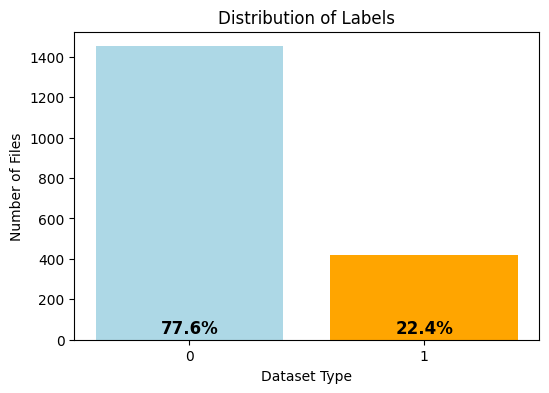

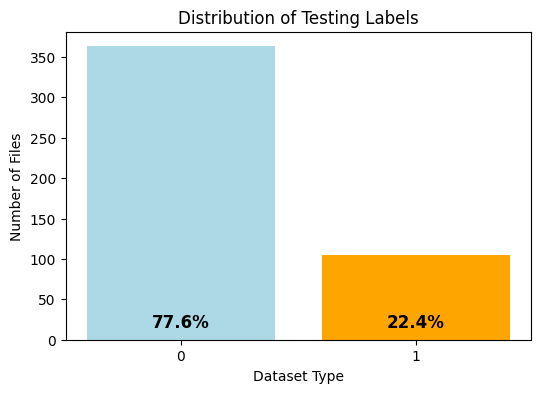

In [ ]:
# Plot distribution of labels in training set
plot_distribution(list(train_label_counts.values()), list(map(str, train_label_counts.keys())), "Distribution of Labels")

# Plot distribution of labels in testing set
plot_distribution(list(test_label_counts.values()), list(map(str, test_label_counts.keys())), "Distribution of Testing Labels")

The distribution is the same as expected - very imbalanced

Data are loaded in based on its location, the shapes are checked once again

In [ ]:
def load_audio_dataset(audio_dir, label_dict):
    """Load only the audio files mentioned in the label dictionary."""
    data = []
    labels = []
    filenames = []
    skipped_files = 0  # Counter for skipped files

    for filename in label_dict.keys():  # Iterate only over filenames in label_dict
        file_path = os.path.join(audio_dir, filename)

        if not os.path.isfile(file_path) or os.path.getsize(file_path) < 10:
            print(f"Skipping {file_path} (file missing or too small)")
            skipped_files += 1
            continue  # Skip missing or small files

        try:
            # Load the audio file
            audio, sr = librosa.load(file_path, sr=None)
            data.append(audio)
            labels.append(label_dict[filename])
            filenames.append(filename)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            skipped_files += 1
            continue  # Skip problematic files

    print(f"Skipped {skipped_files} files due to errors.")
    return np.array(data, dtype=object), np.array(labels), filenames

In [ ]:
# Load train and test datasets from the same directory
X_train, y_train, train_files = load_audio_dataset(train_dir, train_label_dict)
X_test, y_test, test_files = load_audio_dataset(test_dir, test_label_dict)

# Print dataset summary
print(f"Training Data: {X_train.shape[0]} samples")
print(f"Test Data: {X_test.shape[0]} samples")

# Show sample audio shape
print("\nSample training shapes:")
for i, (audio, name) in enumerate(zip(X_train[:5], train_files[:5])):
    print(f"{name}: {audio.shape}")

print("\nSample test shapes:")
for i, (audio, name) in enumerate(zip(X_test[:5], test_files[:5])):
    print(f"{name}: {audio.shape}")

Skipped 0 files due to errors.
Skipped 0 files due to errors.
Training Data: 1871 samples
Test Data: 468 samples

Sample training shapes:
aa78817e-f5e3-470b-b516-6006c59fb1fa.wav: (71680,)
7b7f6998-7f52-475f-8bbd-e76d80eafd91.wav: (105472,)
506b5606-cecb-4fba-8723-c4a2bfb8b038.wav: (103744,)
0f79324e-9dc6-4f6c-8c13-2a3041f044d1.wav: (12800,)
e1d7fad3-6eb9-44db-ad0a-1f25cd555b53.wav: (33792,)

Sample test shapes:
7869b66e-5c53-42b8-8741-8e7398f78137.wav: (16896,)
e80023d9-392a-407a-9580-9c66eb45d7bd.wav: (38912,)
37347587-048a-4a1c-a100-7cf820711428.wav: (24064,)
f0bc6079-5c16-4c95-91be-ddffc7bb37b0.wav: (85504,)
ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav: (64512,)


In [ ]:
def extract_mfcc(audio, sr, n_mfcc=13):
    """Extract MFCC features from raw audio."""
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T  # (frames, features)

# Define a padding/truncation function
def pad_or_truncate(mfcc, target_frames):
    """Pads or truncates MFCC to the target number of frames."""
    num_frames = mfcc.shape[0]

    if num_frames < target_frames:
        # Pad with zeros at the end
        pad_width = target_frames - num_frames
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    elif num_frames > target_frames:
        # Truncate
        mfcc = mfcc[:target_frames, :]

    return mfcc

In [ ]:
# Extract MFCC features at 12kHz
X_train_mfcc = [extract_mfcc(audio, sr=12000) for audio in X_train]
X_test_mfcc = [extract_mfcc(audio, sr=12000) for audio in X_test]

In [ ]:
# Calculate MFCC lengths for all samples
mfcc_lengths = [mfcc.shape[0] for mfcc in X_train_mfcc]

# Compute statistics
min_frames = np.min(mfcc_lengths)
max_frames = np.max(mfcc_lengths)
mean_frames = np.mean(mfcc_lengths)
median_frames = np.median(mfcc_lengths)
percentile_90 = np.percentile(mfcc_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(mfcc_lengths, 95)  # 95th percentile


# Print results
print(f"Min frames: {min_frames}")
print(f"Max frames: {max_frames}")
print(f"Mean frames: {mean_frames}")
print(f"Median frames: {median_frames}")
print(f"90th Percentile frames: {percentile_90}")
print(f"95th Percentile frames: {percentile_95}")

Min frames: 7
Max frames: 233
Mean frames: 90.83270978086584
Median frames: 86.0
90th Percentile frames: 166.0


In [ ]:
# Define target frame size
target_frames = 186

# Apply padding/truncation
X_train_mfcc_padded = np.array([pad_or_truncate(mfcc, target_frames) for mfcc in X_train_mfcc])
X_test_mfcc_padded = np.array([pad_or_truncate(mfcc, target_frames) for mfcc in X_test_mfcc])

# Print final shapes
print(f"Processed Training Data Shape: {X_train_mfcc_padded.shape}")
print(f"Processed Test Data Shape: {X_test_mfcc_padded.shape}")

Processed Training Data Shape: (1871, 186, 13)
Processed Test Data Shape: (468, 186, 13)


In [ ]:
# Compute statistics for X_train_mfcc_padded
train_mfcc_lengths = [mfcc.shape[0] for mfcc in X_train_mfcc_padded]

print("Train MFCC Statistics After Padding:")
print(f"Min frames: {np.min(train_mfcc_lengths)}")
print(f"Max frames: {np.max(train_mfcc_lengths)}")
print(f"Mean frames: {np.mean(train_mfcc_lengths)}")
print(f"Median frames: {np.median(train_mfcc_lengths)}")
print(f"90th percentile frames: {np.percentile(train_mfcc_lengths, 90)}")

# Compute statistics for X_test_mfcc_padded
test_mfcc_lengths = [mfcc.shape[0] for mfcc in X_test_mfcc_padded]

print("\nTest MFCC Statistics After Padding:")
print(f"Min frames: {np.min(test_mfcc_lengths)}")
print(f"Max frames: {np.max(test_mfcc_lengths)}")
print(f"Mean frames: {np.mean(test_mfcc_lengths)}")
print(f"Median frames: {np.median(test_mfcc_lengths)}")
print(f"90th percentile frames: {np.percentile(test_mfcc_lengths, 90)}")


Train MFCC Statistics After Padding:
Min frames: 186
Max frames: 186
Mean frames: 186.0
Median frames: 186.0
90th percentile frames: 186.0

Test MFCC Statistics After Padding:
Min frames: 186
Max frames: 186
Mean frames: 186.0
Median frames: 186.0
90th percentile frames: 186.0


In [ ]:
# Convert MFCC lists to NumPy arrays
X_train_mfcc_padded_fed = np.array(X_train_mfcc_padded)
X_test_mfcc_padded_fed = np.array(X_test_mfcc_padded)

# Add channel dimension if using CNNs
X_train_mfcc_padded_fed = X_train_mfcc_padded_fed[..., np.newaxis]
X_test_mfcc_padded_fed = X_test_mfcc_padded_fed[..., np.newaxis]

# Split training data into train and validation sets
X_train_fed, X_val_fed, y_train_fed, y_val_fed = train_test_split(
    X_train_mfcc_padded_fed, y_train, test_size=0.2, stratify=y_train, random_state=37
)

In [ ]:
# Print final shapes
print(f"X_train shape: {X_train_fed.shape}, y_train shape: {y_train_fed.shape}")
print(f"X_val shape: {X_val_fed.shape}, y_val shape: {y_val_fed.shape}")
print(f"X_test shape: {X_test_mfcc_padded_fed.shape}, y_test shape: {y_test.shape}")

X_train shape: (1496, 186, 13, 1), y_train shape: (1496,)
X_val shape: (375, 186, 13, 1), y_val shape: (375,)
X_test shape: (468, 186, 13, 1), y_test shape: (468,)


## 3. Machine Learning 1 (CNN and LSTM on MFCC)

Some functions are defined to understand the training history. They can be used for all models in this notebook

In [ ]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates a given model on test data, generates predictions,
    plots a confusion matrix, and prints a classification report.

    Parameters:
    - model: Trained model to evaluate
    - X_test: Test input data
    - y_test: True labels for the test data
    - threshold: Probability threshold for binary classification (default: 0.5)
    """
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)  # Convert probabilities to binary labels

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
def evaluate_test_set(model, X_test, y_test):
    """
    Evaluates the given model on the test set and prints the results.

    Parameters:
    - model: Trained model to evaluate
    - X_test: Test input data
    - y_test: True labels for the test data
    """
    # Evaluate the model on the test set
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

Input shape is fixed

In [ ]:
# fix input shape
input_shape = (186, X_train_fed.shape[2], 1)

### Model 1: Simple CNN as a baseline

Firstly, a simple CNN model is trained

SoundCLR

In [ ]:
# Build the CNN model
model_1 = Sequential([
    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 186, 13, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 186, 13, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 93, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 93, 6, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 93, 6, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 46, 3, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 46, 3, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 46, 3, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 23, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2944)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         376,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 478,849 (1.83 MB)

 Trainable params: 478,401 (1.82 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile the model
model_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 30
history_simpleCNN = model_1.fit(X_train_fed, y_train_fed,
                                  batch_size=8,
                                  epochs=num_epochs,
                                  validation_data=(X_val_fed, y_val_fed),
                                  callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6607 - loss: 0.8562 - precision: 0.3013 - recall: 0.3055 - val_accuracy: 0.7733 - val_loss: 0.5309 - val_precision: 0.4444 - val_recall: 0.0476
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7378 - loss: 0.5605 - precision: 0.3790 - recall: 0.2311 - val_accuracy: 0.7813 - val_loss: 0.5237 - val_precision: 0.6667 - val_recall: 0.0476
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7675 - loss: 0.4945 - precision: 0.3990 - recall: 0.1904 - val_accuracy: 0.7760 - val_loss: 0.5041 - val_precision: 0.5000 - val_recall: 0.0238
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7700 - loss: 0.4880 - precision: 0.4497 - recall: 0.2237 - val_accuracy: 0.7920 - val_loss: 0.5186 - val_precision: 0.7500 - val_recall: 0.1071
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7709 - loss: 0.4752 - precision: 0.4292 - recall: 0.2239 - val_accuracy: 0.7867 - val_los

In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_1, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7774 - loss: 0.4779 - precision: 0.4781 - recall: 0.0363
Test Loss: 0.4939
Test Accuracy: 0.7778
Test Precision: 0.5455
Test Recall: 0.0571


It can be seen that the accuracy for the first training of model 1 is quite high (79%) however, the recall is very low. This is likely due to the imbalanced training dataset. The model also conveges very fast. The loss is also quite high

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


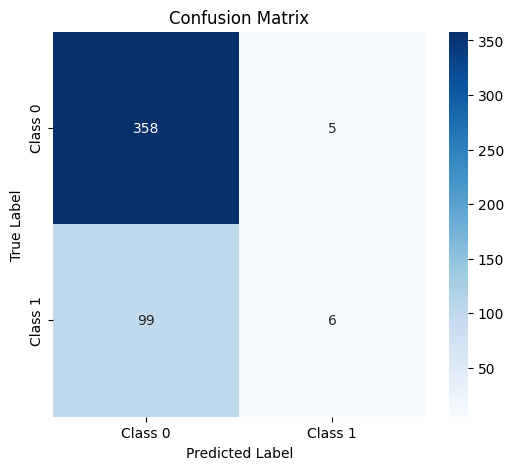


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87       363
           1       0.55      0.06      0.10       105

    accuracy                           0.78       468
   macro avg       0.66      0.52      0.49       468
weighted avg       0.73      0.78      0.70       468



In [ ]:
evaluate_model(model_1, X_test_mfcc_padded_fed, y_test)

From the classification report above, it can be seen that the class 1 has a very low class accuracy. This proves that point from above that despit of the overall good accuracy, the individual classes may not be performing well. The model also converges very fast (4 epoch)


Still the problem is likely due to class imbalance. Thus, the class weight will be calculated and tries to address the issue by setting the classweight to be 'balanced'

### Model 1.2: added class weight when fitting model 1, no changes in the structure

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Convert class labels to a NumPy array
classes = np.array([0, 1])

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fed)

In [ ]:
# Convert to dictionary
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed class weights:", class_weights_dict)

Computed class weights: {0: 0.6448275862068965, 1: 2.2261904761904763}


The model is then retrained using the same structure as model 1

In [ ]:
# Build the CNN model
model_1_1 = Sequential([
    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_1_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
model_1_1.fit(X_train_fed, y_train_fed,
            batch_size=8, epochs=30,
            validation_data=(X_val_fed, y_val_fed),
            callbacks=[early_stopping],
            class_weight=class_weights_dict)

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5666 - loss: 0.9757 - precision: 0.2437 - recall: 0.4539 - val_accuracy: 0.6747 - val_loss: 0.6238 - val_precision: 0.3603 - val_recall: 0.5833
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6084 - loss: 0.7092 - precision: 0.3190 - recall: 0.6150 - val_accuracy: 0.6533 - val_loss: 0.6320 - val_precision: 0.3526 - val_recall: 0.6548
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6349 - loss: 0.6308 - precision: 0.3587 - recall: 0.6746 - val_accuracy: 0.6720 - val_loss: 0.6081 - val_precision: 0.3488 - val_recall: 0.5357
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6794 - loss: 0.6034 - precision: 0.3649 - recall: 0.6824 - val_accuracy: 0.6347 - val_loss: 0.6357 - val_precision: 0.3121 - val_recall: 0.5238
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7013 - loss: 0.5657 - precision: 0.4124 - recall: 0.7568 - val_accuracy: 0.6933 - val_los

In [ ]:
evaluate_test_set(model_1_1, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7307 - loss: 0.5551 - precision: 0.3901 - recall: 0.3993
Test Loss: 0.5857
Test Accuracy: 0.7286
Test Precision: 0.3962
Test Recall: 0.4000


It can be seen that the the model obtained a lower test accuracy but better recall although still not good. The loss is also higher.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


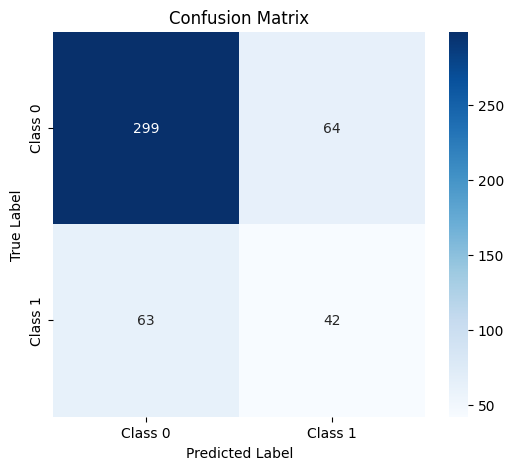


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82       363
           1       0.40      0.40      0.40       105

    accuracy                           0.73       468
   macro avg       0.61      0.61      0.61       468
weighted avg       0.73      0.73      0.73       468



In [ ]:
evaluate_model(model_1_1, X_test_mfcc_padded_fed, y_test)

The confusion matrix and classification report proves that the model is better in predicting the minority class 1 at the expense of a lower overall accuracy. The model also converges very fast (14 epoch)

### Model 2 - Decrease complexity

The following changes are implemented:
*  All layers are regularised as the previouse modle is converging too quickly

*  Dropout rate increased to address potential overfitting

*  adaptive learning rate scheduler is inplemented instead of a fixed learning rate

In [ ]:
# Build the CNN model
model_2 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers with L2 Regularization
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Increased Dropout Rate

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Increased Dropout Rate

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 186, 13, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 186, 13, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 93, 6, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 93, 6, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 93, 6, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 46, 3, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 46, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 46, 3, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 23, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │          94,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 119,905 (468.38 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor
    factor=0.5,           # Factor to reduce the learning rate by (new_lr = old_lr * factor)
    patience=2,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,          # Minimum learning rate
    verbose=1             # Verbosity mode
)

In [ ]:
# Early stopping callback with a larger patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Compile the model
model_2.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model with adaptive learning rate
num_epochs = 50 # allow more potentail epoch, there is early stopping to prevent overfitting
history_regularisedCNN = model_2.fit(
    X_train_fed, y_train_fed,
    batch_size=8,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5789 - loss: 3.5894 - precision: 0.2626 - recall: 0.4645 - val_accuracy: 0.6720 - val_loss: 2.9145 - val_precision: 0.3415 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5545 - loss: 3.1312 - precision: 0.2809 - recall: 0.5789 - val_accuracy: 0.5387 - val_loss: 2.9165 - val_precision: 0.2829 - val_recall: 0.6905 - learning_rate: 1.0000e-04
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5762 - loss: 2.9480 - precision: 0.2829 - recall: 0.5788 - val_accuracy: 0.5840 - val_loss: 2.8458 - val_precision: 0.3043 - val_recall: 0.6667 - learning_rate: 1.0000e-04
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5546 - loss: 2.8941 - precision: 0.2737 - recall: 0.6118 - val_accuracy: 0.6933 - val_loss: 2.7569 - val_precision: 0.3524 - val_recall: 0.4405 - learning_rate: 1.0000e-04
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 1

In [ ]:
evaluate_test_set(model_2, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7271 - loss: 1.3053 - precision: 0.4040 - recall: 0.4954
Test Loss: 1.3482
Test Accuracy: 0.7137
Test Precision: 0.3858
Test Recall: 0.4667


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


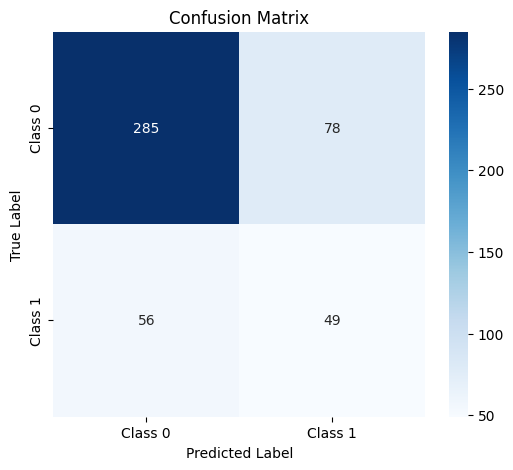


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81       363
           1       0.39      0.47      0.42       105

    accuracy                           0.71       468
   macro avg       0.61      0.63      0.62       468
weighted avg       0.73      0.71      0.72       468



In [ ]:
evaluate_model(model_2, X_test_mfcc_padded_fed, y_test)

### Model 2.2 - Monitor on AUC

As the data is imbalanced, an experiement is conducted on monitoring AUC in training with best model as of now(model 2) without changing its structure.

It provides insights into the model's ability to separate the two classes across all thresholds, making it more reliable for imbalanced datasets than accuracy alone.

In [ ]:
# Early stopping callback with a larger patience
early_stopping = EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, mode='max')

In [ ]:
# Build the CNN model
model_2_2 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers with L2 Regularization
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Increased Dropout Rate

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Increased Dropout Rate

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_2_2.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_monitorAUC = model_2_2.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.3850 - loss: 3.7636 - precision: 0.2151 - recall: 0.6767 - val_accuracy: 0.6587 - val_loss: 2.9262 - val_precision: 0.3036 - val_recall: 0.4048 - learning_rate: 1.0000e-04
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4978 - loss: 3.1116 - precision: 0.2548 - recall: 0.6063 - val_accuracy: 0.7040 - val_loss: 2.9067 - val_precision: 0.3483 - val_recall: 0.3690 - learning_rate: 1.0000e-04
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5499 - loss: 2.9778 - precision: 0.2779 - recall: 0.5991 - val_accuracy: 0.6613 - val_loss: 2.8750 - val_precision: 0.3097 - val_recall: 0.4167 - learning_rate: 1.0000e-04
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5542 - loss: 2.8920 - precision: 0.2610 - recall: 0.5960 - val_accuracy: 0.5867 - val_loss: 2.8602 - val_precision: 0.2848 - val_recall: 0.5595 - learning_rate: 1.0000e-04
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/s

In [ ]:
evaluate_test_set(model_2_2, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7638 - loss: 1.4275 - precision: 0.4577 - recall: 0.3818
Test Loss: 1.5243
Test Accuracy: 0.7543
Test Precision: 0.4375
Test Recall: 0.3333


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


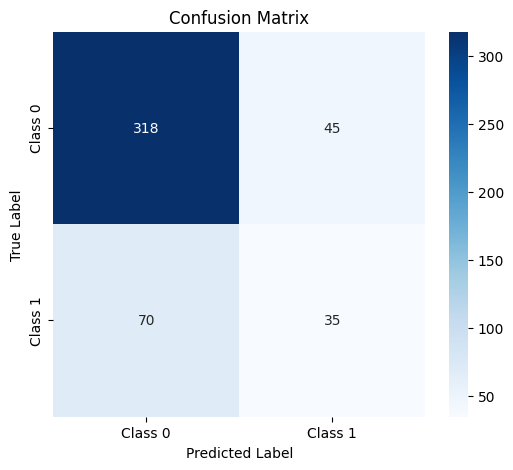


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       363
           1       0.44      0.33      0.38       105

    accuracy                           0.75       468
   macro avg       0.63      0.60      0.61       468
weighted avg       0.73      0.75      0.74       468



In [ ]:
evaluate_model(model_2_2, X_test_mfcc_padded_fed, y_test)

early stopping is not called by the end of the training. The model still performce badly

### Model 3 - CNN-LSTM

In [ ]:
# Reset back the early stopping conditions:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Build the CNN-LSTM Model
model_3 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Reshape output for LSTM compatibility
    Reshape((-1, 64)),  # Convert feature map to (time_steps, features)

    # LSTM Layer
    LSTM(64, return_sequences=False),  # Use return_sequences=True for stacking LSTMs
    Dropout(0.5),

    # Fully Connected Layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

In [ ]:
# Compile the model
model_3.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_cnnlstm = model_3.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.3718 - loss: 2.4472 - precision: 0.1973 - recall: 0.6082 - val_accuracy: 0.2400 - val_loss: 2.3598 - val_precision: 0.2247 - val_recall: 0.9762 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3817 - loss: 2.3457 - precision: 0.2280 - recall: 0.6804 - val_accuracy: 0.4027 - val_loss: 2.2581 - val_precision: 0.2535 - val_recall: 0.8571 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4405 - loss: 2.2386 - precision: 0.2567 - recall: 0.7436 - val_accuracy: 0.4133 - val_loss: 2.1723 - val_precision: 0.2536 - val_recall: 0.8333 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4519 - loss: 2.1429 - precision: 0.2427 - recall: 0.6821 - val_accuracy: 0.4533 - val_loss: 2.0840 - val_precision: 0.2609 - val_recall: 0.7857 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step -

In [ ]:
evaluate_test_set(model_3, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7417 - loss: 0.9188 - precision: 0.4325 - recall: 0.5411
Test Loss: 0.9225
Test Accuracy: 0.7415
Test Precision: 0.4375
Test Recall: 0.5333


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


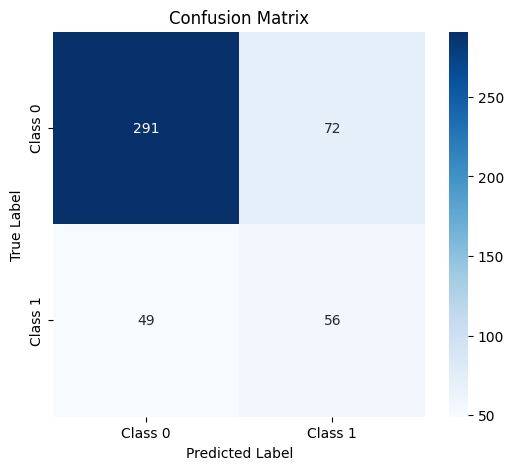


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       363
           1       0.44      0.53      0.48       105

    accuracy                           0.74       468
   macro avg       0.65      0.67      0.65       468
weighted avg       0.76      0.74      0.75       468



In [ ]:
evaluate_model(model_3, X_test_mfcc_padded_fed, y_test)

### model 3.2 removing regularisation

In [ ]:
# Build the CNN-LSTM Model
model_3_2 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same', ),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Reshape output for LSTM compatibility
    Reshape((-1, 64)),  # Convert feature map to (time_steps, features)

    # LSTM Layer
    LSTM(64, return_sequences=False),  # Use return_sequences=True for stacking LSTMs
    Dropout(0.5),

    # Fully Connected Layers
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_3_2.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_cnnlstm_complex = model_3_2.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4594 - loss: 0.7296 - precision: 0.2385 - recall: 0.5797 - val_accuracy: 0.4480 - val_loss: 0.6808 - val_precision: 0.2550 - val_recall: 0.7619 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5322 - loss: 0.6895 - precision: 0.2064 - recall: 0.4085 - val_accuracy: 0.4400 - val_loss: 0.6796 - val_precision: 0.2595 - val_recall: 0.8095 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4871 - loss: 0.6897 - precision: 0.2463 - recall: 0.6189 - val_accuracy: 0.4693 - val_loss: 0.6686 - val_precision: 0.2634 - val_recall: 0.7619 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5466 - loss: 0.6838 - precision: 0.2636 - recall: 0.5814 - val_accuracy: 0.6640 - val_loss: 0.6500 - val_precision: 0.3521 - val_recall: 0.5952 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step -

In [ ]:
evaluate_test_set(model_3_2, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6698 - loss: 0.6357 - precision: 0.3686 - recall: 0.6904
Test Loss: 0.6387
Test Accuracy: 0.6667
Test Precision: 0.3665
Test Recall: 0.6667


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


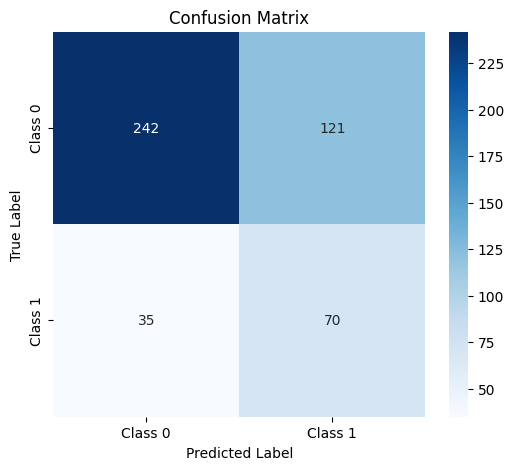


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.67      0.76       363
           1       0.37      0.67      0.47       105

    accuracy                           0.67       468
   macro avg       0.62      0.67      0.61       468
weighted avg       0.76      0.67      0.69       468



In [ ]:
evaluate_model(model_3_2, X_test_mfcc_padded_fed, y_test)

### Model 3.3 Trying bidirectional LSTM

In [ ]:
# Build the CNN-LSTM Model
model_3_3 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Reshape output for LSTM compatibility
    Reshape((-1, 64)),  # Convert feature map to (time_steps, features)

    # LSTM Layer
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),

    # Fully Connected Layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_3_3.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_cnnlstm_complex = model_3_3.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.5128 - loss: 2.4225 - precision: 0.2510 - recall: 0.5754 - val_accuracy: 0.7920 - val_loss: 2.3074 - val_precision: 0.5882 - val_recall: 0.2381 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5092 - loss: 2.3162 - precision: 0.2637 - recall: 0.6322 - val_accuracy: 0.7760 - val_loss: 2.2053 - val_precision: 0.5000 - val_recall: 0.2857 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5561 - loss: 2.2318 - precision: 0.2702 - recall: 0.5473 - val_accuracy: 0.7520 - val_loss: 2.1179 - val_precision: 0.4400 - val_recall: 0.3929 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5698 - loss: 2.1353 - precision: 0.2938 - recall: 0.6262 - val_accuracy: 0.7440 - val_loss: 2.0410 - val_precision: 0.4400 - val_recall: 0.5238 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step 

In [ ]:
evaluate_test_set(model_3_3, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7415 - loss: 1.0606 - precision: 0.4204 - recall: 0.4549
Test Loss: 1.0674
Test Accuracy: 0.7415
Test Precision: 0.4298
Test Recall: 0.4667


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


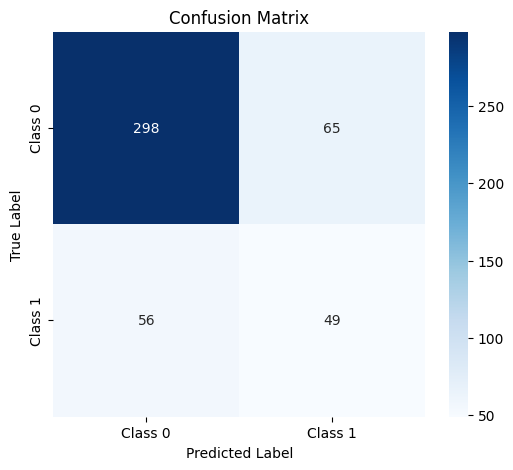


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       363
           1       0.43      0.47      0.45       105

    accuracy                           0.74       468
   macro avg       0.64      0.64      0.64       468
weighted avg       0.75      0.74      0.75       468



In [ ]:
evaluate_model(model_3_3, X_test_mfcc_padded_fed, y_test)

Not as good as LSTM

## 4. Machine learning 2 (log-mel)

Beside MFCC, log mel spectrogram is also commonly used


In [ ]:
def extract_logmel(audio, sr):
    """Extract logmel features from raw audio."""
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64, fmax=6000)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max).T
    return log_mel  # (frames, features)

In [ ]:
# Process all audio files to extract log-mel features
X_train_logmel = [extract_logmel(audio, sr=12000) for audio in X_train]
X_test_logmel = [extract_logmel(audio, sr=12000) for audio in X_test]

In [ ]:
#Calculate log-mel lengths for all training samples
logmel_lengths = [logmel.shape[0] for logmel in X_train_logmel]

# Compute statistics for log-mel frames
min_frames = np.min(logmel_lengths)
max_frames = np.max(logmel_lengths)
mean_frames = np.mean(logmel_lengths)
median_frames = np.median(logmel_lengths)
percentile_90 = np.percentile(logmel_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(logmel_lengths, 95)  # 95th percentile


# Print results
print(f"Log-mel Statistics:")
print(f"Min frames: {min_frames}")
print(f"Max frames: {max_frames}")
print(f"Mean frames: {mean_frames:.2f}")
print(f"Median frames: {median_frames}")
print(f"90th Percentile frames: {percentile_90}")
print(f"95th Percentile frames: {percentile_95}")

Log-mel Statistics:
Min frames: 7
Max frames: 233
Mean frames: 90.83
Median frames: 86.0
90th Percentile frames: 166.0
95th Percentile frames: 186.0


In [ ]:
# Function to pad or truncate log-mel features to 186 frames
def process_logmel_features(features, target_frames=186):
    """Pad or truncate log-mel spectrograms to the target number of frames."""
    return np.array([pad_or_truncate(f, target_frames) for f in features]) #reuse pad or truncte

In [ ]:
# Apply padding/truncation to log-mel features
X_train_logmel_padded = process_logmel_features(X_train_logmel, 186)[..., np.newaxis]
X_test_logmel_padded = process_logmel_features(X_test_logmel, 186)[..., np.newaxis]

# Check the final shapes
print(f"X_train_logmel_padded shape: {X_train_logmel_padded.shape}")
print(f"X_test_logmel_padded shape: {X_test_logmel_padded.shape}")

X_train_logmel_padded shape: (1871, 186, 64, 1)
X_test_logmel_padded shape: (468, 186, 64, 1)


In [ ]:
# Convert log-mel lists to NumPy arrays (if not already)
X_train_logmel_padded = np.array(X_train_logmel_padded)
X_test_logmel_padded = np.array(X_test_logmel_padded)

# Add channel dimension if not already present
X_train_logmel_padded = X_train_logmel_padded[..., np.newaxis]
X_test_logmel_padded = X_test_logmel_padded[..., np.newaxis]

# Split training data into train and validation sets USE SPLIT INSTEAD OF FED
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_logmel_padded, y_train, test_size=0.2, stratify=y_train, random_state=37
)

# Print the shapes to verify the split
print(f"X_train_split shape: {X_train_split.shape}")
print(f"X_val_split shape: {X_val_split.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"y_val_split shape: {y_val_split.shape}")
print(f"X_test_logmel_padded shape: {X_test_logmel_padded.shape}")

X_train_split shape: (1496, 186, 64, 1, 1)
X_val_split shape: (375, 186, 64, 1, 1)
y_train_split shape: (1496,)
y_val_split shape: (375,)
X_test_logmel_padded shape: (468, 186, 64, 1, 1)


In [ ]:
# Remove the extra channel dimension
X_train_split = np.squeeze(X_train_split, axis=-1)
X_val_split = np.squeeze(X_val_split, axis=-1)
X_test_logmel_padded = np.squeeze(X_test_logmel_padded, axis=-1)

# Check shapes after squeezing
print(f"Fixed X_train_split shape: {X_train_split.shape}")
print(f"Fixed X_val_split shape: {X_val_split.shape}")
print(f"Fixed X_test_logmel_padded shape: {X_test_logmel_padded.shape}")

Fixed X_train_split shape: (1496, 186, 64, 1)
Fixed X_val_split shape: (375, 186, 64, 1)
Fixed X_test_logmel_padded shape: (468, 186, 64, 1)


In [ ]:
print(X_train_split.shape, y_train_split.shape)
print(X_val_split.shape, y_val_split.shape)
print(X_test_logmel_padded.shape, y_test.shape)

(1496, 186, 64, 1) (1496,)
(375, 186, 64, 1) (375,)
(468, 186, 64, 1) (468,)


In [ ]:
# Build the CNN model
model_4 = Sequential([
    # Convolutional Layers
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(186, 64, 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten Layer
    Flatten(name="flatten"),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

In [ ]:
# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Print the model summary
model_4.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)                   │ (None, 186, 64, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_72               │ (None, 186, 64, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 93, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 93, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_73               │ (None, 93, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 46, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 46, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_74               │ (None, 46, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 23, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11776)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 32)                  │         376,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,641 (1.53 MB)

 Trainable params: 400,417 (1.53 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Train the model
num_epochs = 50
history_logmel= model_4.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5377 - loss: 1.8702 - precision: 0.2721 - recall: 0.6921 - val_accuracy: 0.5653 - val_loss: 1.8587 - val_precision: 0.2953 - val_recall: 0.6786 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.5885 - loss: 1.8178 - precision: 0.3423 - recall: 0.7257 - val_accuracy: 0.6533 - val_loss: 1.7794 - val_precision: 0.3562 - val_recall: 0.6786 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6504 - loss: 1.7645 - precision: 0.3986 - recall: 0.7293 - val_accuracy: 0.6267 - val_loss: 1.7211 - val_precision: 0.3272 - val_recall: 0.6310 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.6088 - loss: 1.7173 - precision: 0.3374 - recall: 0.7774 - val_accuracy: 0.6693 - val_loss: 1.6631 - val_precision: 0.3551 - val_recall: 0.5833 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step -

In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_4, X_test_logmel_padded , y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7908 - loss: 1.1456 - precision: 0.5362 - recall: 0.4096
Test Loss: 1.2129
Test Accuracy: 0.7842
Test Precision: 0.5256
Test Recall: 0.3905


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


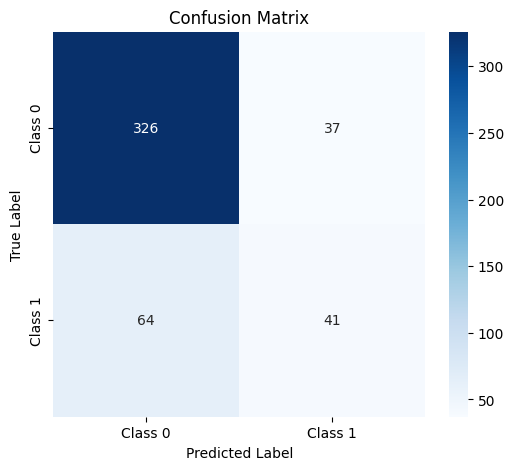


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       363
           1       0.53      0.39      0.45       105

    accuracy                           0.78       468
   macro avg       0.68      0.64      0.66       468
weighted avg       0.77      0.78      0.77       468



In [ ]:
evaluate_model(model_4, X_test_logmel_padded, y_test)

### Model 5

Increase complexity of model by doubling the filter size

In [ ]:
model_5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(186,64,1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_5.compile(optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_logmel= model_5.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.5382 - loss: 1.2713 - precision: 0.2142 - recall: 0.4519 - val_accuracy: 0.3893 - val_loss: 0.7779 - val_precision: 0.2456 - val_recall: 0.8333 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.5607 - loss: 0.8593 - precision: 0.2707 - recall: 0.6315 - val_accuracy: 0.5947 - val_loss: 0.6720 - val_precision: 0.3068 - val_recall: 0.6429 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.6409 - loss: 0.6904 - precision: 0.3481 - recall: 0.6544 - val_accuracy: 0.5440 - val_loss: 0.6898 - val_precision: 0.2769 - val_recall: 0.6429 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.6233 - loss: 0.6468 - precision: 0.3444 - recall: 0.6846 - val_accuracy: 0.6507 - val_loss: 0.6199 - val_precision: 0.3444 - val_recall: 0.6190 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 15

In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_5, X_test_logmel_padded , y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7179 - loss: 0.5753 - precision: 0.4113 - recall: 0.6409
Test Loss: 0.6041
Test Accuracy: 0.7009
Test Precision: 0.3871
Test Recall: 0.5714


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


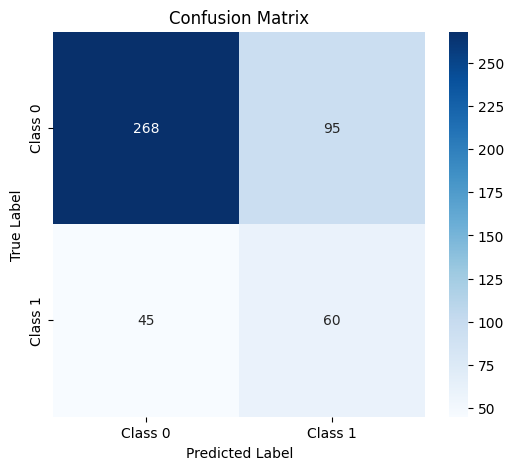


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79       363
           1       0.39      0.57      0.46       105

    accuracy                           0.70       468
   macro avg       0.62      0.65      0.63       468
weighted avg       0.75      0.70      0.72       468



In [ ]:
evaluate_model(model_5, X_test_logmel_padded, y_test)

### Model 6 CNN+LSTM

In [ ]:
model_6 = Sequential([
    # CNN feature extractor
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(186,64,1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # At this point, the feature map should be roughly of shape (23, 8, 128)
    # Reshape to (time_steps, features) for the LSTM layers
    Reshape((23, 8 * 128)),

    # LSTM layers to capture temporal dynamics
    LSTM(128, return_sequences=False),
    Dropout(0.5),

    # Fully connected layers for classification
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [ ]:
# Compile the model
model_6.compile(optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_logmel_cnnlstm= model_6.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.5174 - loss: 0.7136 - precision: 0.2809 - recall: 0.6700 - val_accuracy: 0.4507 - val_loss: 0.6950 - val_precision: 0.2598 - val_recall: 0.7857 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.5429 - loss: 0.6854 - precision: 0.2511 - recall: 0.5413 - val_accuracy: 0.4213 - val_loss: 0.7281 - val_precision: 0.2546 - val_recall: 0.8214 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5543 - loss: 0.6862 - precision: 0.2699 - recall: 0.5799
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.5541 - loss: 0.6862 - precision: 0.2699 - recall: 0.5800 - val_accuracy: 0.4667 - val_loss: 0.6974 - val_precision: 0.2642 - val_recall: 0.7738 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.5708 - loss: 0.6476 - precis

In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_6, X_test_logmel_padded , y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7356 - loss: 0.5865 - precision: 0.4311 - recall: 0.5960
Test Loss: 0.5919
Test Accuracy: 0.7244
Test Precision: 0.4167
Test Recall: 0.5714


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


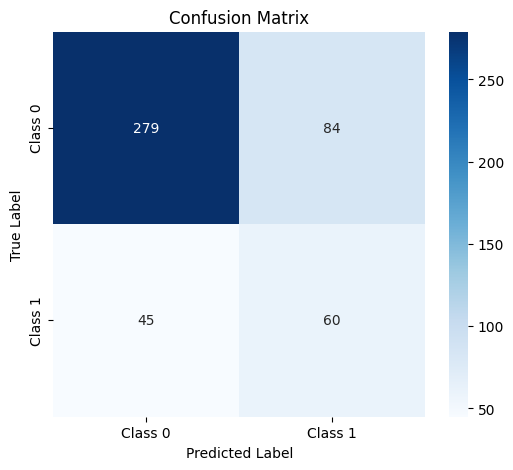


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81       363
           1       0.42      0.57      0.48       105

    accuracy                           0.72       468
   macro avg       0.64      0.67      0.65       468
weighted avg       0.76      0.72      0.74       468



In [ ]:
evaluate_model(model_6, X_test_logmel_padded, y_test)

## 5. Fusion

In [ ]:
# Branch 1: model_6 (Log-mel spectrogram branch)
input_6 = Input(shape=(186, 64, 1), name="logmel_input")
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_6)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
# Expected shape after pooling ~ (23, 8, 128)
x = Reshape((23, 8 * 128))(x)

x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
# Feature vector from branch 1
feature_6 = x

In [ ]:
# Branch 2: model_3 (MFCC branch)
input_3 = Input(shape=(186, 13, 1), name="mfcc_input")
y = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_3)
y = BatchNormalization()(y)
y = MaxPooling2D((2, 2))(y)

y = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(y)
y = BatchNormalization()(y)
y = MaxPooling2D((2, 2))(y)

y = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(y)
y = BatchNormalization()(y)
y = MaxPooling2D((2, 2))(y)
# Reshape for LSTM; note: the new shape depends on the output dimensions from pooling.
y = Reshape((-1, 64))(y)

y = LSTM(64, return_sequences=False)(y)
y = Dropout(0.5)(y)

y = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(y)
y = Dropout(0.5)(y)
y = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(y)
y = Dropout(0.5)(y)
# Feature vector from branch 2
feature_3 = y

In [ ]:
# Fusion
combined = Concatenate()([feature_6, feature_3])

# Additional layers after fusion
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(64, activation='relu')(z)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)  # Final binary classification

In [ ]:
# Build the fused model
fused_model = Model(inputs=[input_6, input_3], outputs=output)

In [ ]:
# Compile the model
fused_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [ ]:
fused_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ logmel_input (InputLayer) │ (None, 186, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfcc_input (InputLayer)   │ (None, 186, 13, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 186, 64, 32)    │            320 │ logmel_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 186, 13, 16)    │            160 │ mfcc_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_93    │ (None, 186, 64, 32)    │            128 │ conv2d_90[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 186, 13, 16)    │             64 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_90          │ (None, 93, 32, 32)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_96          │ (None, 93, 6, 16)      │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 93, 32, 64)     │         18,496 │ max_pooling2d_90[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 93, 6, 32)      │          4,640 │ max_pooling2d_96[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 93, 32, 64)     │            256 │ conv2d_91[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 93, 6, 32)      │            128 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_91          │ (None, 46, 16, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_97          │ (None, 46, 3, 32)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 46, 16, 128)    │         73,856 │ max_pooling2d_91[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 841,761 (3.21 MB)

 Trainable params: 841,089 (3.21 MB)

 Non-trainable params: 672 (2.62 KB)

In [ ]:
fused_history = fused_model.fit([X_train_split, X_train_fed], y_train_split,
                                batch_size=16,
                                epochs=50,
                                validation_data=([X_val_split, X_val_fed], y_val_split),
                                callbacks=[early_stopping, lr_scheduler],
                                class_weight=class_weights_dict)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.4464 - loss: 2.3956 - precision: 0.2216 - recall: 0.5477 - val_accuracy: 0.4000 - val_loss: 2.2689 - val_precision: 0.2509 - val_recall: 0.8452 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.4957 - loss: 2.2501 - precision: 0.2416 - recall: 0.5156 - val_accuracy: 0.5360 - val_loss: 2.1133 - val_precision: 0.2897 - val_recall: 0.7381 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.5474 - loss: 2.1197 - precision: 0.2672 - recall: 0.4856 - val_accuracy: 0.4213 - val_loss: 2.0041 - val_precision: 0.2546 - val_recall: 0.8214 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.5645 - loss: 1.9547 - precision: 0.2856 - recall: 0.6495 - val_accuracy: 0.4560 - val_loss: 1.9062 - val_precision: 0.2619 - val_recall: 0.7857 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 16

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7841 - loss: 0.5284 - precision: 0.5113 - recall: 0.5373
Test Loss: 0.5416
Test Accuracy: 0.7650
Test Precision: 0.4757
Test Recall: 0.4667
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


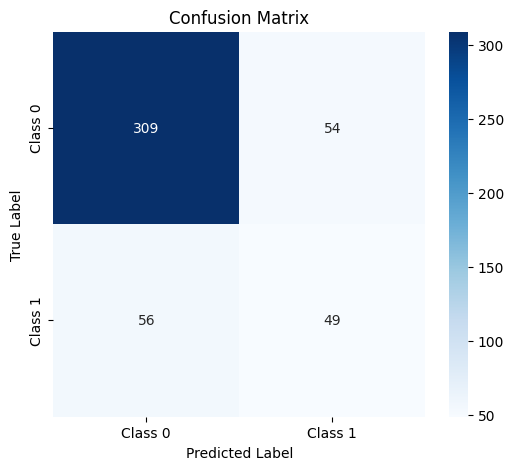

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       363
           1       0.48      0.47      0.47       105

    accuracy                           0.76       468
   macro avg       0.66      0.66      0.66       468
weighted avg       0.76      0.76      0.76       468



In [ ]:
test_loss, test_accuracy, test_precision, test_recall = fused_model.evaluate(
    [X_test_logmel_padded, X_test_mfcc_padded_fed], y_test
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions from the model
y_pred_probs = fused_model.predict([X_test_logmel_padded, X_test_mfcc_padded_fed])
y_pred = (y_pred_probs > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

### attention instead of fusion

add attention layer after concatenation to learn features that are more important, it weights the features from each branch.

In [ ]:
combined_att = Concatenate()([feature_6, feature_3])

# Create an attention branch that outputs weights for the combined feature vector
attention = Dense(160, activation='sigmoid')(combined)  # 160 = 128 + 32
attended = Multiply()([combined, attention])

# Additional layers after fusion
a = Dense(128, activation='relu')(attended)
a = Dropout(0.3)(a)
a = Dense(64, activation='relu')(a)
a = Dropout(0.3)(a)
output = Dense(1, activation='sigmoid')(a)  # Final binary classification

# Build the fused model
fused_model_att = Model(inputs=[input_6, input_3], outputs=output)

In [ ]:
# Compile the model
fused_model_att.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

fused_model_att.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ logmel_input (InputLayer) │ (None, 186, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfcc_input (InputLayer)   │ (None, 186, 13, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 186, 64, 32)    │            320 │ logmel_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 186, 13, 16)    │            160 │ mfcc_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_93    │ (None, 186, 64, 32)    │            128 │ conv2d_90[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 186, 13, 16)    │             64 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_90          │ (None, 93, 32, 32)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_96          │ (None, 93, 6, 16)      │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 93, 32, 64)     │         18,496 │ max_pooling2d_90[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 93, 6, 32)      │          4,640 │ max_pooling2d_96[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 93, 32, 64)     │            256 │ conv2d_91[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 93, 6, 32)      │            128 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_91          │ (None, 46, 16, 64)     │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_97          │ (None, 46, 3, 32)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 46, 16, 128)    │         73,856 │ max_pooling2d_91[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 867,521 (3.31 MB)

 Trainable params: 866,849 (3.31 MB)

 Non-trainable params: 672 (2.62 KB)

In [ ]:
fused_att_history = fused_model_att.fit([X_train_split, X_train_fed], y_train_split,
                                batch_size=16,
                                epochs=50,
                                validation_data=([X_val_split, X_val_fed], y_val_split),
                                callbacks=[early_stopping, lr_scheduler],
                                class_weight=class_weights_dict)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.5551 - loss: 0.7049 - precision: 0.2784 - recall: 0.6252 - val_accuracy: 0.7627 - val_loss: 0.6241 - val_precision: 0.4793 - val_recall: 0.6905 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.7665 - loss: 0.5900 - precision: 0.4849 - recall: 0.7584 - val_accuracy: 0.7707 - val_loss: 0.4997 - val_precision: 0.4907 - val_recall: 0.6310 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.7802 - loss: 0.5098 - precision: 0.5030 - recall: 0.7686 - val_accuracy: 0.7573 - val_loss: 0.5119 - val_precision: 0.4673 - val_recall: 0.5952 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8208 - loss: 0.4528 - precision: 0.5853 - recall: 0.8310 - val_accuracy: 0.7627 - val_loss: 0.4913 - val_precision: 0.4737 - val_recall: 0.5357 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 17

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7395 - loss: 0.5402 - precision: 0.4350 - recall: 0.5795
Test Loss: 0.5333
Test Accuracy: 0.7415
Test Precision: 0.4394
Test Recall: 0.5524
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step


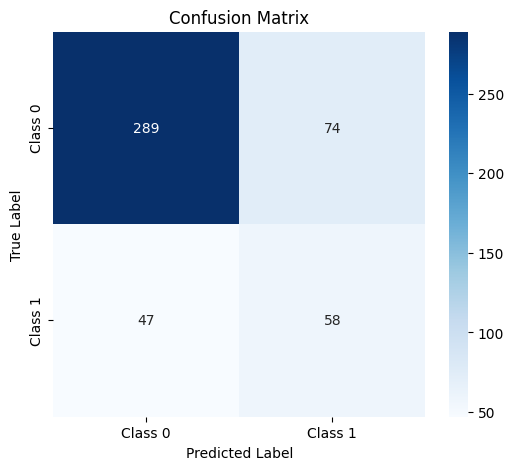

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       363
           1       0.44      0.55      0.49       105

    accuracy                           0.74       468
   macro avg       0.65      0.67      0.66       468
weighted avg       0.77      0.74      0.75       468



In [ ]:
test_loss, test_accuracy, test_precision, test_recall = fused_model_att.evaluate(
    [X_test_logmel_padded, X_test_mfcc_padded_fed], y_test
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions from the model
y_pred_probs = fused_model_att.predict([X_test_logmel_padded, X_test_mfcc_padded_fed])
y_pred = (y_pred_probs > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))